# Import packages

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

import OncoMarkAI as oma
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Plot setting

In [2]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()

2023-07-19 15:26:39|INFO|plotting|Figure setting updated


In [3]:
rna_B2M = pd.read_csv("../OncoMarkAI/data/datasets/B2M_mRNA_expression_z-scores_relative_to_normal samples_logRNASeqV2RSEM.txt", sep="\t", index_col=1)[['B2M']]
rna_IGSF8 = pd.read_csv("../OncoMarkAI/data/datasets/IGSF8_mRNA_expression_z-scores_relative_to_normal samples_logRNASeqV2RSEM.txt", sep="\t", index_col=1)[['IGSF8']]
rna = rna_B2M.join(rna_IGSF8)
rna["PatientID"] = [idx[:-3] for idx in rna.index]

In [4]:
rna = rna[~rna["PatientID"].duplicated()]
patient_meta_cBio = pd.read_csv("/Users/caibin/Documents/CodeCommit/XBH25-paper/pan-cancer_analysis/data/tumor.related.information/combined_study_clinical_data.tsv", sep="\t")
patient_meta_cBio = patient_meta_cBio[["Patient ID","TCGA PanCanAtlas Cancer Type Acronym"]].drop_duplicates().set_index(['Patient ID'])
rna.loc[:, "TCGA_project"] = rna["PatientID"].map(patient_meta_cBio['TCGA PanCanAtlas Cancer Type Acronym'])

In [5]:
def grouping(tmp, gene, low_boundary=-1, high_boundary=1):
    # Categorize the DataFrame
    tmp.loc[:, gene] = tmp[gene].replace("NP", np.nan).astype(float)
    conditions = [
        tmp[gene] <= low_boundary,
        (tmp[gene] > low_boundary) & (tmp[gene] <= high_boundary),
        tmp[gene] > high_boundary
    ]
    choices = [f'{gene} down-regulation', f'{gene} no-difference', f'{gene} up-regulation']

    return np.select(conditions, choices, default='unknown')

In [6]:
for gene in ["IGSF8", "B2M"]:
    rna[f'{gene}-groups'] = grouping(rna, gene, low_boundary=-1, high_boundary=1)

In [7]:
def calculate_fraction(rna, col):
    
    gene = col.replace("-groups", '')
    tmp = rna[[col, 'TCGA_project', 'PatientID']]
    tmp = tmp[tmp[col]!='unknown']
    result = tmp.groupby(['TCGA_project', col]).size() / tmp.groupby(['TCGA_project']).size()
    result = result.to_frame(f'Fraction_{gene}') * 100
    result = result.reset_index()
    result = result.pivot(index='TCGA_project', columns=col, values=f'Fraction_{gene}')
    return result
    # return tmp

In [8]:
IGSF8_frac = calculate_fraction(rna, col='IGSF8-groups')
B2M_frac = calculate_fraction(rna, col='B2M-groups')

frac = IGSF8_frac.join(B2M_frac)

In [9]:
frac = frac.reindex(['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC']).dropna()
frac = frac.sort_values(['B2M down-regulation'], ascending=False)
frac["B2M down-regulation & IGSF8 up-regulation"] = frac["B2M down-regulation"] + frac["IGSF8 up-regulation"]
frac = frac.sort_values(['B2M down-regulation & IGSF8 up-regulation'], ascending=False)

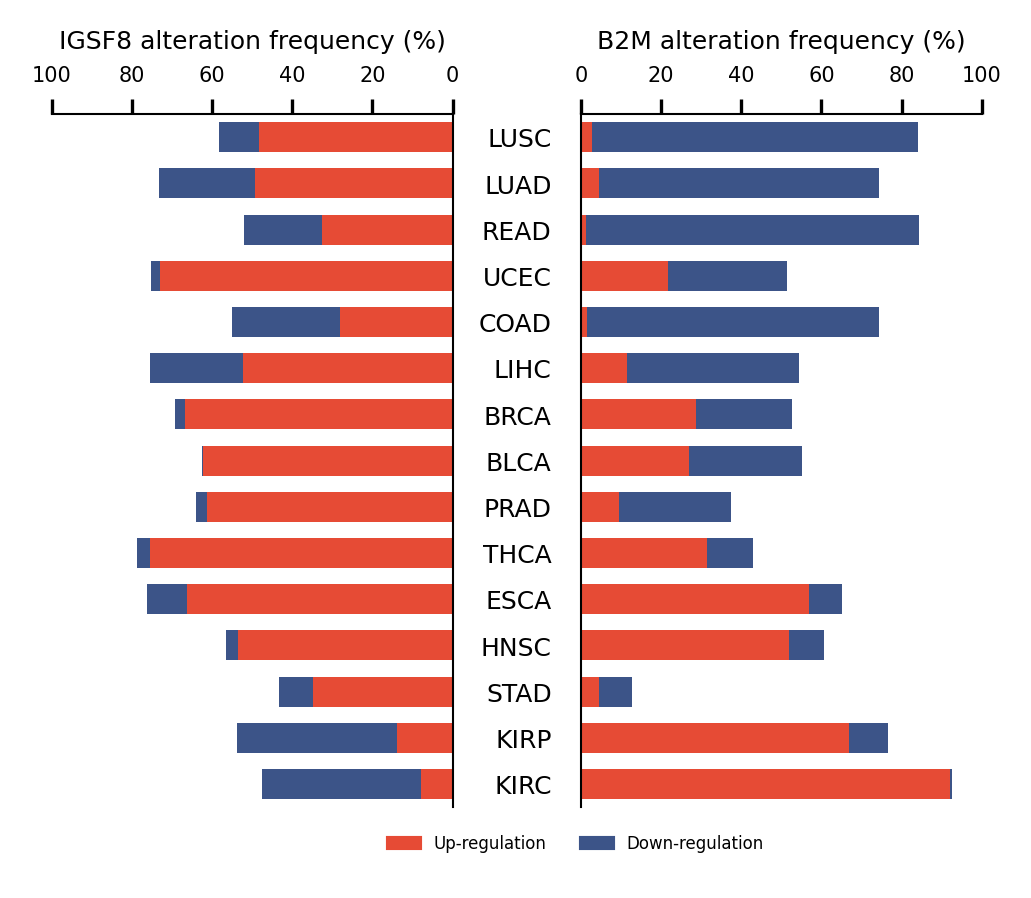

In [10]:
width = .65

for gene in ['B2M']:
    
    tmp = frac.loc[:, frac.columns.str.startswith(gene)]
    IGSF8_group = frac.loc[:, frac.columns.str.startswith('IGSF8')]
    tmp = tmp.join(IGSF8_group)
    tmp[f"IGSF8 up-regulation & {gene} down-regulation"] = tmp["IGSF8 up-regulation"] + tmp[f"{gene} down-regulation"]
    tmp = tmp.loc[::-1].dropna()
    # tmp = tmp.sort_values(f"IGSF8 up-regulation & {gene} down-regulation", ascending=True).dropna()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3), gridspec_kw={'wspace': .32}, )#width_ratios=[.49,.51]

    left = np.zeros(tmp.shape[0])
    for col, a, c in zip(['IGSF8 up-regulation', 'IGSF8 down-regulation'], [1, 1], (cmap.npg_palette(0), cmap.npg_palette(3))):
        p = axes[0].barh(tmp.reset_index().index, 
                         tmp[col], width, 
                         label=col, 
                         left=left, 
                         color=c, 
                         linewidth=.5,
                        ) #alpha=a, 

        left += tmp[col].values
        axes[0].set_xlim(100, 0)
        axes[0].set_ylim(-.5, frac.shape[0]-.5)
        axes[0].tick_params(left=False)  # remove the ticks
        axes[0].set_yticklabels("")  # remove the ticks
        axes[0].xaxis.set_ticks_position('top')
        axes[0].set(ylabel="", xlabel="IGSF8 alteration frequency (%)");
        axes[0].xaxis.set_label_position('top')
        axes[0].spines['bottom'].set_visible(False)
        axes[0].spines['left'].set_visible(False)        
        axes[0].legend("",frameon=False, loc='lower left', bbox_to_anchor=(-0.075, -0.1), ncols=2)


        # ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize=6);
        # ax.legend_.remove()

        
    left = np.zeros(tmp.shape[0])
    for col, a, c in zip([f'{gene} up-regulation', f'{gene} down-regulation'], [ .75, .75], (cmap.npg_palette(0), cmap.npg_palette(3))): #.25,
        p = axes[1].barh(tmp.reset_index().index, 
                         tmp[col], 
                         width, 
                   label=col, 
                   left=left, 
                   color=c, 
                   linewidth=.5, 
                        )

        left += tmp[col].values

    axes[1].set_ylim(-.5, frac.shape[0]-.5)
    axes[1].set_xlim(0., 100)
    axes[1].tick_params(left=False) # remove the ticks
    axes[1].xaxis.set_ticks_position('top')

    axes[1].set_yticks(tmp.reset_index().index, list(tmp.index),  fontsize=6, ha='right', rotation_mode='default'); #rotation=90, horizontalalignment='center',)
    # axes[1].legend(frameon=False, loc='lower left', bbox_to_anchor=(-0.05, -0.1), ncols=2)
    axes[1].legend("", frameon=False, loc='lower left', bbox_to_anchor=(-0.05, -0.1), ncols=2)
    axes[1].set(ylabel="", xlabel="B2M alteration frequency (%)");
    axes[1].xaxis.set_label_position('top')
    axes[1].spines['bottom'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    
    from matplotlib.patches import Patch
    handles = [
        Patch(edgecolor=fc, facecolor=fc, label=label, linewidth=.75) 
        for label, ec, fc in zip(['Up-regulation', 'Down-regulation'], [cmap.npg_palette(0), cmap.npg_palette(3)], [cmap.npg_palette(0), cmap.npg_palette(3)])
    ]
    axes[1].legend(handles=handles, loc=(-.5, -0.075), ncols=2, fontsize=4., frameon=False);

    plt.savefig(f"../figures/Fig3d.pdf", bbox_inches = "tight")